#Universidad Nacional de Colombia

##Minería de Datos

Luis Alejandro Mongua López - lamongual@unal.edu.co

Ivanhoe Rozo Rojas - irozor@unal.edu.co

Camilo Alfonso Mosquera Benavides - camosquerab@unal.edu.co

## **Proyecto de data mining**

_Septiembre 2022_


##Descripción general del dataset
El dataset corresponde a los resultados de las revisiones técnico-mecánicas de varias topologías de vehículos en CDAs (Centros de Diagnóstico Automotor) en todo el país entre los años 2014 y 2022, incluye algunos valores cualitativos y otros cuantitativos. La cantidad de registros se estima en 900.000, organizados en 34 variables.

Es de anotar que algunos datos no aplican para algunos tipos de vehículo, por ejemplo, las motocicletas no cuentan con valores cuantitativos del estado de la suspensión, y los vehículos que funcionan con combustible diesel no tienen valores en los campos de emisiones de HC, CO, CO2 ni O2 (sus emisiones se miden en porcentaje de opacidad).

Los datos fueron extraídos de la base de datos de inspecciones de varios CDA y fueron anonimizados para no violar las políticas de privacidad y protección de datos personales.

Primero importamos las librerías que vamos a usar

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Definimos la constante que contiene las columnas que nos interesan para este análisis

In [ ]:
CAMPOS_GASES = [
    'gases__ralenti__co',
    'gases__ralenti__co2',
    'gases__ralenti__hc',
    'gases__ralenti__o2',
    'modelo',
    'marca',
    'linea',
    'kilometraje',
    'codigo_resultado',
    'secuencia',
    'fecha_fin',
]

## Integracion
El dataset es recolectado de los diferentes bases de datos integrando los datos encontrados en documentos csv de diferentes revisiones de los distintos CDA; con el dataset integrado se carga en el drive para tener acceso a el.

Se carga el dataset

In [ ]:
df = pd.read_hdf('/content/drive/Shareddrives/Data_mining/dataset.hdf')
df

,adherencia__eje1__de,adherencia__eje1__iz,adherencia__eje2__de,adherencia__eje2__iz,desviacion_lateral__eje1,desviacion_lateral__eje2,frenos__eficacia_total,frenos__eficacia_auxiliar,frenos__desequilibrio_eje_1,frenos__desequilibrio_eje_2,...,combustible,marca,linea,kilometraje,tipo_motor,tipo_revision_id,codigo_resultado,secuencia,fecha_inicio,fecha_fin
8117952,NaN,NaN,NaN,NaN,-0.41,-0.25,62.0,25.7,16.10,22.2,...,DIESEL,HINO,10812,146286,DIESEL,3,1,1,2021-01-29 13:33:08-05:00,2021-01-29 14:48:44-05:00
913054,67.8,62.2,87.2,78.4,-0.01,-0.01,64.3,13.1,20.30,19.1,...,GASOLINA,KIA,CERATO PRO EX,82100,OTTO,1,1,1,2022-01-14 07:34:09-05:00,2022-01-14 08:20:35-05:00
2217068,NaN,NaN,NaN,NaN,NaN,NaN,63.2,NaN,NaN,NaN,...,GASOLINA,HONDA,BIZ 125,0,4T,4,1,2,2022-07-28 11:07:04-05:00,2022-07-28 11:48:48-05:00
898636,NaN,NaN,NaN,NaN,NaN,NaN,89.8,NaN,NaN,NaN,...,GASOLINA,SUZUKI,BEST 125,55165,4T,4,1,2,2017-12-15 13:52:01-05:00,2017-12-15 14:01:02-05:00
3761017,77.5,52.6,52.3,73.5,0.00,0.00,18.5,9.6,23.70,26.4,...,GASOLINA,LAND ROVER,109,20573,,1,2,1,2019-12-28 07:51:25-05:00,2019-12-28 09:59:17-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781047,NaN,NaN,NaN,NaN,NaN,NaN,74.7,NaN,NaN,NaN,...,GASOLINA,KYMCO,UNI-K 110,1,4T,4,1,2,2021-09-03 09:08:45-05:00,2021-09-03 09:33:17-05:00
1673841,67.1,76.3,45.8,61.8,-0.87,-11.90,62.5,9.9,0.18,4.5,...,GASOLINA,CHEVROLET,OPTRA,138677,OTTO,1,1,1,2021-11-10 10:49:40-05:00,2021-11-10 11:39:10-05:00
6354895,NaN,NaN,NaN,NaN,NaN,NaN,86.6,NaN,NaN,NaN,...,GASOLINA,HONDA,CB 160F STD,38500,4T,4,1,1,2020-11-20 08:53:54-05:00,2020-11-20 10:09:57-05:00
6236540,51.3,71.7,72.5,77.7,1.70,0.30,70.5,16.9,22.50,7.1,...,DIESEL,NISSAN,UP 720,352987,,1,1,1,2020-06-16 14:54:18-05:00,2020-06-16 16:45:37-05:00


Se filtran los registros con los que vamos a trabajar:

* tipo de revisión 1, que corresponde a automóviles livianos.
* Tipo de Combustible: gasolina

Se extraen las columnas que nos interesan

In [ ]:
carros_df = df[(df['tipo_revision_id'] == 1) & (df['combustible'] == 'GASOLINA')][CAMPOS_GASES]

In [ ]:
carros_df.shape

(393689, 11)

## Tratamiento de valores perdidos

Actualmente se tiene un dataset de las siguientes dimensiones:

In [ ]:
carros_df.shape

(393689, 11)

Como el dataset es relativamente extenso, podemos eliminar los registros que tengan valores faltantes

In [ ]:
carros_df.dropna(how='any', inplace=True)

Después de esto, tenemos un dataset aún lo suficientemente grande


In [ ]:
carros_df.shape

(381806, 11)

## Eliminar duplicados

Se eliminan en el dataset los registros duplicados, sin embargo, para esto no tenemos en cuenta las columnas _kilometraje_, *codigo_resultado* y _secuencia_, ya que la principal razón para encontrar valores repetidos es debido a que los vehículos, cuando su prueba de emisiones de gases es aprobada pero tienen algún defecto en otro item, deben presentarse nuevamente en el CDA pero la prueba de gases no se realiza nuevamente, por lo que los datos de la inspección anterior se conservan.

In [ ]:
def eliminar_duplicados(dataframe, campos_ignorados):
    """Se eliminan los registros duplicados"""
    # No se tienen en cuenta algunos campos
    columnas_para_duplicados = list(dataframe.columns)
    for campo in campos_ignorados:
        columnas_para_duplicados.remove(campo)

    dataframe.drop_duplicates(inplace=True, subset=columnas_para_duplicados)

eliminar_duplicados(carros_df, ['kilometraje', 'codigo_resultado', 'secuencia'])

# Muestreo

Sacar el promedio en el conjunto completo de los datos es una función muy demorada. Por lo tanto lo que hacemos es sacar un promedio de una muestra, en este caso, del 10 % de los datos. La computación es mucho más rápida y el resultado es muy parecido al promedio del conjunto de datos completo.

Lo mismo aplica para la desviación estándar

In [ ]:
sample_df = carros_df.sample(frac=0.1)

mean = sample_df._get_numeric_data().mean()
stdev = sample_df._get_numeric_data().std()

## Detección de outliers

Se eliminan los valores que sabemos que no tienen sentido. Los carros inspeccionados son carros usados, por lo tanto no tienen sentido kilometrajes demasiado bajos:


In [ ]:
def eliminar_valores_incoherentes(dataframe, campos):
    """
    Se eliminan los valores que, desde el conocimiento de los datos
    se sabe que corresponden a errores en la lectura del dato o en la
    digitación
    Esta función recibe como parámetros el dataframe y un diccionario
    de campos donde cada llave tiene asociado un array de longitud 2
    donde se almacena el límite inferior y el límite superior respectivamente
    de los valores que se consideran coherentes
    """
    for campo in campos:
        niveles = campos[campo]
        lim_inferior = niveles[0]
        lim_superior = niveles[1]

        dataframe = dataframe[(dataframe[campo] > lim_inferior) & (dataframe[campo] < lim_superior)]
    
    return dataframe

carros_df = eliminar_valores_incoherentes(carros_df, {
  'gases__ralenti__co': [-0.5, 25],
  'gases__ralenti__co2': [-0.5, 25],
  'gases__ralenti__hc': [-0.5, 2**16],
  'gases__ralenti__o2': [-0.5, 25],
  'kilometraje': [101, 10**6],
  'secuencia': [0, 3]
})
carros_df.shape

(345391, 11)

Ahora podemos intentar detectar los outliers con base en el algoritmo de K vecinos cercanos 

https://towardsdatascience.com/k-nearest-neighbors-knn-for-anomaly-detection-fdf8ee160d13

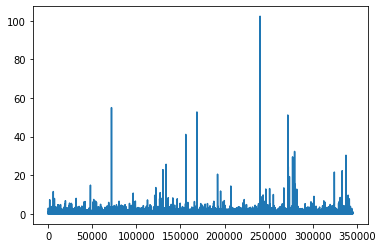

In [ ]:
CAMPOS_DE_INTERES = [
    'gases__ralenti__co',
    'gases__ralenti__co2',
    'gases__ralenti__o2',
    'gases__ralenti__hc',
]

# Se realiza normalización por z_score y se extraen los valores que nos 
# interesan
X = ((carros_df[CAMPOS_DE_INTERES] - mean) / stdev)[CAMPOS_DE_INTERES].values

# Instanciar modelo
nbrs = NearestNeighbors(n_neighbors = 100)

# Se entrena el modelo
nbrs.fit(X)

# Se calcula la distancia a los 100 vecinos más cercanos para cada medición
distances, indexes = nbrs.kneighbors(X)

# Se calcula la media de las 100 distancias para cada punto
mean_distance = distances.mean(axis=1)

# Se grafican los resultados
plt.plot(mean_distance)
plt.show()

Creamos un dataset de distancias para analizar estos datos

In [ ]:
distancias_df = pd.DataFrame({'distancia': mean_distance}, index=carros_df.index)

distancias_df.describe()

,distancia
count,345391.000000
mean,0.110388
std,0.358668
min,0.000931
25%,0.031981
50%,0.063224
75%,0.112612
max,102.304509


Podemos apreciar que hay una fuerte tendencia de los datos hacia el cero. Podemos intentar un valor de umbral de detección de outliers en una distancia de 1

In [ ]:
carros_df = carros_df[distancias_df['distancia'] <= 1]
carros_df.shape

(342717, 11)

## Agregación

Se va a realizar la agrupacion por linea de carros con la intencion de observar el promedio de emision de gases contaminantes de los vehiculos automotores, con el fin de intentar encontrar las líneas de vehículos que tienen las emisiones contaminantes más bajas 

In [ ]:
# Se calcula el tamaño de cada grupo
grouped_size = carros_df.groupby(['marca', 'linea']).size()

# Se calcula el promedio de cada grupo
grouped_mean = carros_df.groupby(['marca', 'linea']).mean()

# Se crea un nuevo dataset
agregado = pd.concat([grouped_size, grouped_mean], axis=1, sort=False)

# Se seleccionan los registros con más de 100 datos
agregado = agregado[grouped_size > 100]

# Se ordena por promedio de CO para hacernos una idea de las líneas que menos contaminan
agregado = agregado.sort_values(by=['gases__ralenti__co'])

# Mostramos el dataset
agregado.head(20)

,,0,gases__ralenti__co,gases__ralenti__co2,gases__ralenti__hc,gases__ralenti__o2,modelo,kilometraje,codigo_resultado,secuencia
marca,linea,,,,,,,,,
MAZDA,CX-5,545,0.027083,14.685383,30.269706,0.673299,2014.781651,91204.183486,1.023853,1.029358
SUZUKI,CELERIO,130,0.033385,14.748538,17.746154,0.487000,2013.907692,74128.707692,1.023077,1.046154
RENAULT,CLIO STYLE,183,0.034645,14.399454,34.427869,0.910055,2016.163934,83718.918033,1.071038,1.071038
HONDA,CR V EX L C AT,151,0.037748,14.721060,17.642384,0.376093,2012.311258,91297.026490,1.033113,1.026490
MAZDA,2,3204,0.042797,14.726764,22.025974,0.506964,2012.275593,95197.977216,1.058989,1.050250
RENAULT,SANDERO GT LINE,660,0.043545,14.484758,33.310758,0.567561,2012.524242,95096.219697,1.087879,1.066667
HONDA,CR-V EXL,144,0.045139,14.831290,21.719375,0.302150,2010.930556,105294.770833,1.020833,1.076389
RENAULT,STEPWAY,3238,0.045409,14.537711,36.597393,0.561031,2012.334775,102322.565781,1.079988,1.076899
MAZDA,215HA8,450,0.045867,14.502819,29.806400,0.587175,2008.895556,118832.420000,1.055556,1.104444


# Discretización

Se crea un atributo "artificial" llamado _antiguedad_ para almacenar la edad del vehículo en el momento de la prueba

In [ ]:
carros_df['antiguedad'] = carros_df['fecha_fin'].map(lambda x: x.year) - carros_df['modelo']

# Se eliminan las dos columnas ahora innecesarias: fecha_fin y modelo
carros_df.drop(['modelo', 'fecha_fin'], axis=1, inplace=True)

A continuación se va a discretizar las variables de _antigüedad_ y _kilometraje_, que darán una indicación del uso que ha tenido el vehículo

Primero dibujaremos histogramas para hacernos una idea de la distrubución de los datos

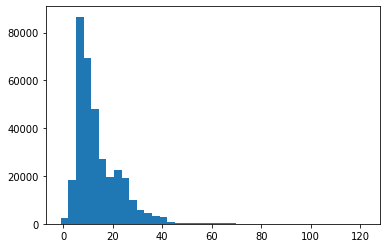

In [ ]:
plt.hist(carros_df['antiguedad'], bins=40)
plt.show()

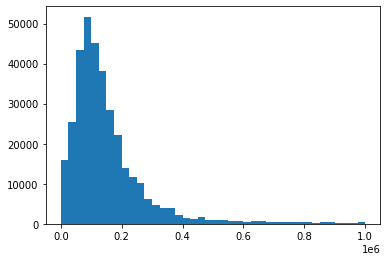

In [ ]:
plt.hist(carros_df['kilometraje'], bins=40)
plt.show()

Usaremos una discretización de frecuencia constante usando la función qcut

Intervalo 1: [102.0 - 66339.4)
Intervalo 2: [66339.4 - 100456.0)
Intervalo 3: [100456.0 - 139249.0)
Intervalo 4: [139249.0 - 206341.8)
Intervalo 5: [206341.8 - 999999.0)


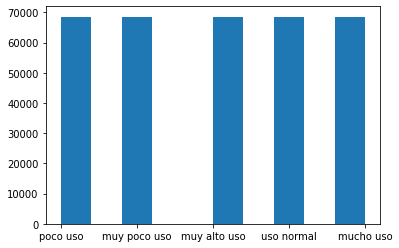

In [ ]:
uso, bins = pd.qcut(carros_df['kilometraje'], 5, labels=[
    'muy poco uso',
    'poco uso',
    'uso normal',
    'mucho uso',
    'muy alto uso',
], retbins=True)

# Renombrar
uso.rename(index='uso', inplace=True)

# Imprima los intervalos
for i in range(1, len(bins)):
  print(f'Intervalo {i}: [{bins[i - 1]} - {bins[i]})')

# Eliminamos la columna original
carros_df.drop('kilometraje', axis= 1, inplace=True)

plt.hist(uso)
plt.show()

Ahora se discretizará la antigüedad:

Intervalo 1: [-1.0 - 7.0)
Intervalo 2: [7.0 - 10.0)
Intervalo 3: [10.0 - 13.0)
Intervalo 4: [13.0 - 21.0)
Intervalo 5: [21.0 - 122.0)


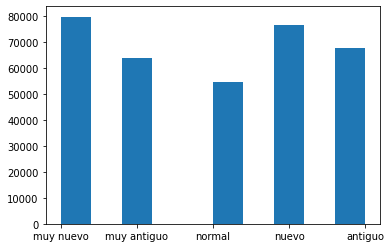

In [ ]:
edad, bins = pd.qcut(carros_df['antiguedad'], 5, labels=[
    'muy nuevo',
    'nuevo',
    'normal',
    'antiguo',
    'muy antiguo',
], retbins=True)

# Renombrar
edad.rename(index='edad', inplace=True)

# Imprima los intervalos
for i in range(1, len(bins)):
  print(f'Intervalo {i}: [{bins[i - 1]} - {bins[i]})')

# Eliminamos la columna original
carros_df.drop('antiguedad', axis= 1, inplace=True)

plt.hist(edad)
plt.show()

In [ ]:
# Únalo con el resto del dataset
carros_df = pd.concat([carros_df, uso, edad], axis=1)
carros_df

,gases__ralenti__co,gases__ralenti__co2,gases__ralenti__hc,gases__ralenti__o2,marca,linea,codigo_resultado,secuencia,uso,edad
913054,0.00,14.6,26.0,0.26,KIA,CERATO PRO EX,1,1,poco uso,muy nuevo
3761017,0.20,11.8,326.0,3.50,LAND ROVER,109,2,1,muy poco uso,muy antiguo
8834532,0.06,14.2,0.0,1.40,RENAULT,KOLEOS EXPRESSION,1,1,poco uso,muy nuevo
4255001,2.23,12.1,319.0,1.20,ISUZU,CARIBE 442,1,1,muy alto uso,muy antiguo
6001432,0.09,11.8,0.0,1.40,CHEVROLET,OPTRA,1,1,poco uso,normal
...,...,...,...,...,...,...,...,...,...,...
5702914,0.65,14.6,105.0,0.60,CHEVROLET,LUV,2,1,muy poco uso,antiguo
6696626,0.05,14.2,74.0,1.20,RENAULT,LOGAN PH1,1,2,uso normal,nuevo
2927482,0.01,14.7,51.0,0.04,HYUNDAI,TUCSON iX35 GL,1,1,muy poco uso,muy nuevo
1298381,0.12,13.9,10.0,0.12,VOLKSWAGEN,JETTA GLI,1,1,muy poco uso,muy nuevo


## Binarización

Es posible binarizar las columnas que poseen valores nominales. En este caso, binarizaremos las columnas codigo_resultado y secuencia para poder tener columnas que describan mejor los campos que estos valores representan

In [ ]:
columns = ['codigo_resultado',	'secuencia']
data = carros_df[columns]

# Binarizamos las columnas
for column in columns:
  one_hot = pd.get_dummies(data[column], prefix=column)
  carros_df.drop(column, axis=1, inplace=True)
  carros_df = carros_df.join(one_hot)

# Renombramos las columas para que describan mejor su contenido
carros_df.rename(columns={
      'codigo_resultado_1': 'aprobado',
      'codigo_resultado_2': 'reprobado',
      'secuencia_1': 'primera_inspeccion',
      'secuencia_2': 'reinspeccion',
    },
    inplace=True)

carros_df

,gases__ralenti__co,gases__ralenti__co2,gases__ralenti__hc,gases__ralenti__o2,marca,linea,uso,edad,aprobado,reprobado,primera_inspeccion,reinspeccion
913054,0.00,14.6,26.0,0.26,KIA,CERATO PRO EX,poco uso,muy nuevo,1,0,1,0
3761017,0.20,11.8,326.0,3.50,LAND ROVER,109,muy poco uso,muy antiguo,0,1,1,0
8834532,0.06,14.2,0.0,1.40,RENAULT,KOLEOS EXPRESSION,poco uso,muy nuevo,1,0,1,0
4255001,2.23,12.1,319.0,1.20,ISUZU,CARIBE 442,muy alto uso,muy antiguo,1,0,1,0
6001432,0.09,11.8,0.0,1.40,CHEVROLET,OPTRA,poco uso,normal,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5702914,0.65,14.6,105.0,0.60,CHEVROLET,LUV,muy poco uso,antiguo,0,1,1,0
6696626,0.05,14.2,74.0,1.20,RENAULT,LOGAN PH1,uso normal,nuevo,1,0,0,1
2927482,0.01,14.7,51.0,0.04,HYUNDAI,TUCSON iX35 GL,muy poco uso,muy nuevo,1,0,1,0
1298381,0.12,13.9,10.0,0.12,VOLKSWAGEN,JETTA GLI,muy poco uso,muy nuevo,1,0,1,0


## Reducción de dimensionalidad

Conocemos de antemano que los resultados de la medición de gases están correlacionados, porque son producto de un mismo proceso de combustión, así que podemos intentar reducir la dimencionalidad de estos cuatro valores en 2 componentes principales para de esta manera poder dibujar los datos

In [ ]:
# Definir las características que, para el caso de estudio, corresponden a las emisiones
features = ['gases__ralenti__co',	'gases__ralenti__co2', 'gases__ralenti__hc',	'gases__ralenti__o2']

# Separar las características 'features'
x = carros_df.loc[:, features].values

# Separar las características 'features'
y = carros_df.loc[:,['marca']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

x.shape

(342717, 4)

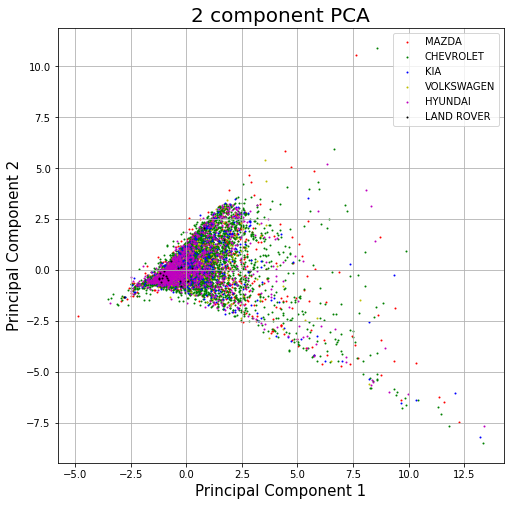

In [ ]:
pca = PCA(n_components=2) # Se definen componentes
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([principalDf, df[['marca']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
marca = ['MAZDA', 'CHEVROLET','KIA', 'VOLKSWAGEN', 'HYUNDAI', 'LAND ROVER']
colors = ['r', 'g', 'b','y', 'm', 'k'] #Definir colores
for target, color in zip(marca,colors):
    indicesToKeep = finalDf['marca'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
                , c = color
               , s = 1)
ax.legend(marca)
ax.grid()